<a href="https://colab.research.google.com/github/nidhisingh2309/BTP-Sem-7/blob/main/XceptionRe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7372 - dice_coef: 0.7363 - loss: 1.2505 - val_accuracy: 0.7901 - val_dice_coef: 0.7163 - val_loss: 0.5667
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - accuracy: 0.7922 - dice_coef: 0.7797 - loss: 0.5175 - val_accuracy: 0.7901 - val_dice_coef: 0.7853 - val_loss: 0.5179
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 898ms/step - accuracy: 0.7909 - dice_coef: 0.7911 - loss: 0.5158 - val_accuracy: 0.7901 - val_dice_coef: 0.7875 - val_loss: 0.5162
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 851ms/step - accuracy: 0.7923 - dice_coef: 0.7902 - loss: 0.5128 - val_accuracy: 0.7901 - val_dice_coef: 0.7809 - val_loss: 0.5157
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 869ms/step - accuracy: 0.7904 - dice_coef: 0.7878 - loss: 0.5144 - val_accuracy: 0.7901 - val_dice_coef: 0.7866 - val_loss: 0.5143
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 904ms/step - accuracy: 0.7913 - dice_coef: 0.7891 - loss: 0.5126 - val_accuracy: 0.7901 - val_d

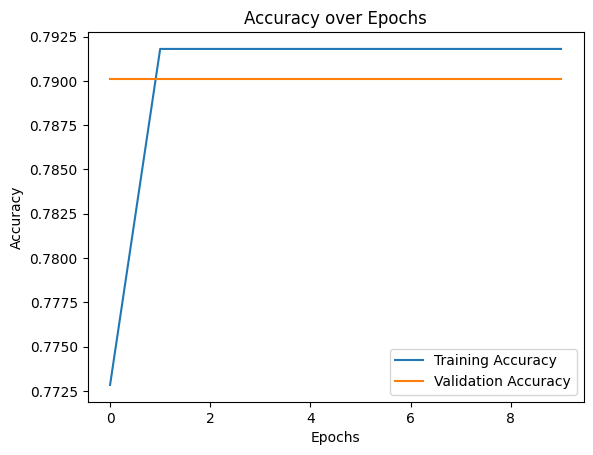

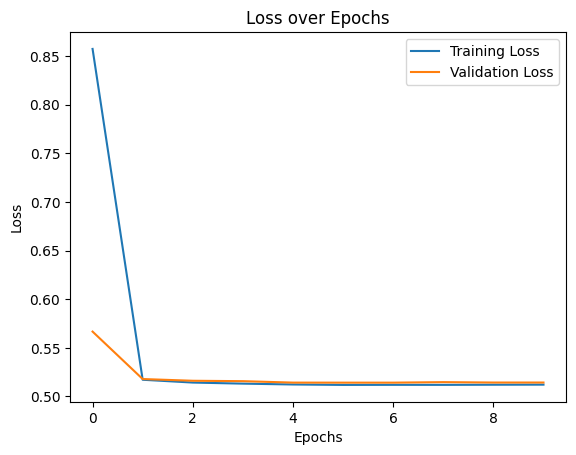

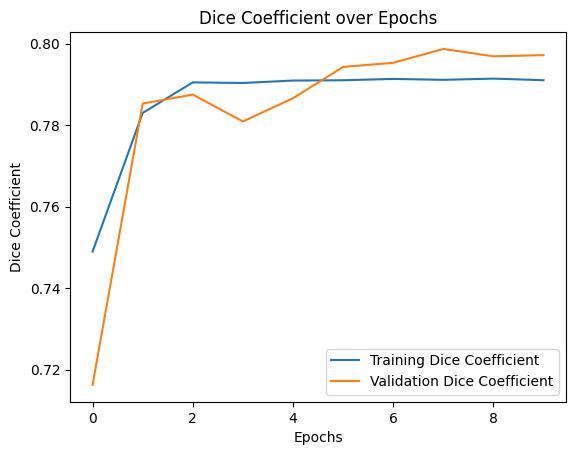

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to your zip file and extraction
zip_path = '/content/drive/MyDrive/Grain_img.zip'  # Update this path
extract_path = '/content/extracted_images'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_folder = os.path.join(extract_path, 'Grain_img', 'RG')
mask_folder = os.path.join(extract_path, 'Grain_img', 'RGMask')

# Load and preprocess images
def load_data(image_folder, mask_folder, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        # Load images and masks in grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize and normalize images and masks
        image = cv2.resize(image, img_size).astype(np.float32) / 255.0
        mask = cv2.resize(mask, img_size).astype(np.float32) / 255.0
        mask = np.where(mask > 0.5, 1.0, 0.0)

        # Convert single-channel grayscale to three channels by stacking
        image = np.stack((image,) * 3, axis=-1)  # Shape: (256, 256, 3)
        mask = np.expand_dims(mask, axis=-1)     # Shape: (256, 256, 1)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, y = load_data(image_folder, mask_folder)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Load the model from .h5 file
model = tf.keras.models.load_model('/content/drive/MyDrive/xception_unet_model.h5', custom_objects={'dice_coef': dice_coef})

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef])

# Train the model with dummy data to collect history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot Dice Coefficient
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


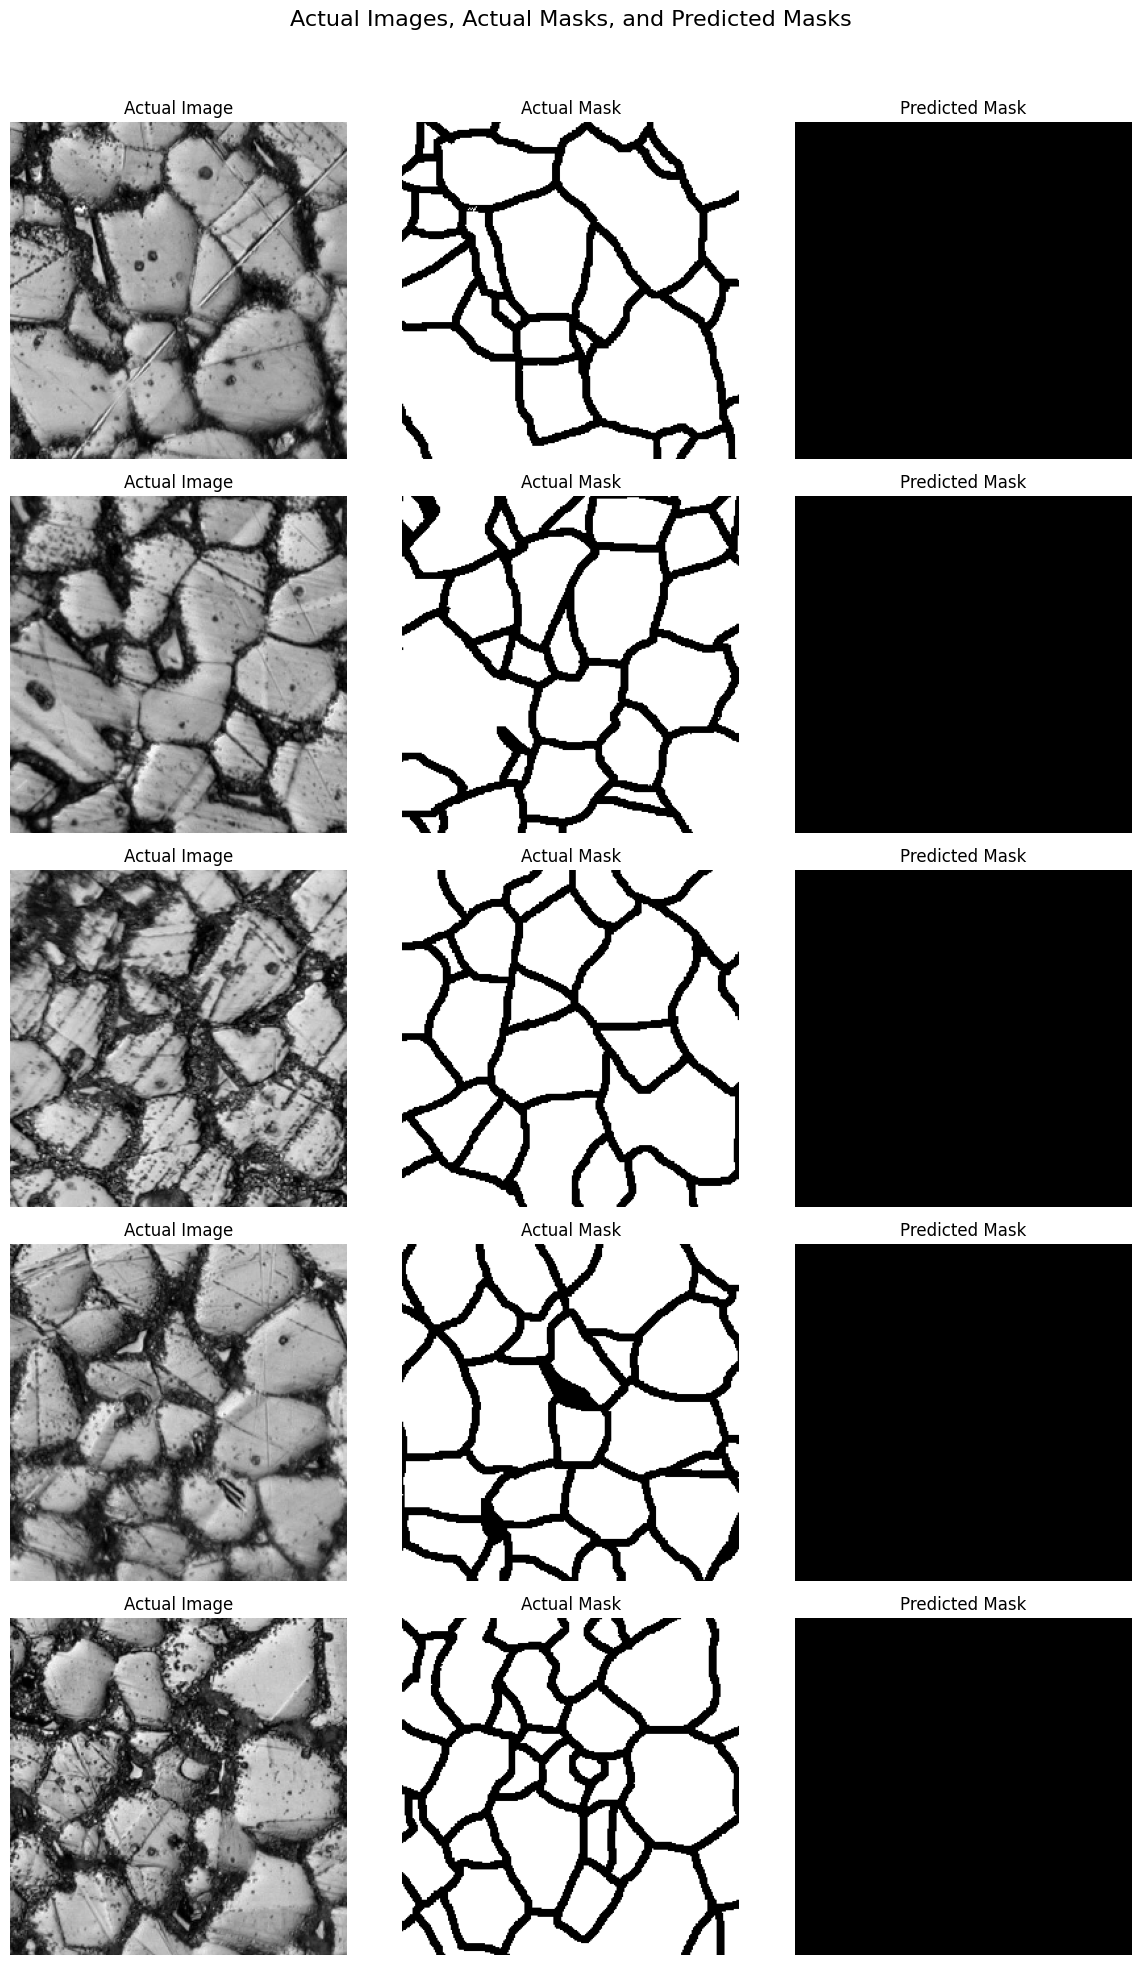

In [ ]:
import matplotlib.pyplot as plt

# Select a few samples from the validation set
num_samples = 5  # Number of samples to display
sample_indices = np.random.choice(len(X_val), num_samples, replace=False)

# Make predictions on the selected samples
predicted_masks = model.predict(X_val[sample_indices])

# Plot actual images, actual masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
fig.suptitle("Actual Images, Actual Masks, and Predicted Masks", fontsize=16)

for i, idx in enumerate(sample_indices):
    actual_image = X_val[idx]
    actual_mask = y_val[idx].squeeze()  # Remove channel dimension for visualization
    predicted_mask = (predicted_masks[i].squeeze() > 0.5).astype(np.float32)  # Threshold prediction to binary

    # Display the actual image
    axes[i, 0].imshow(actual_image, cmap='gray')
    axes[i, 0].set_title("Actual Image")
    axes[i, 0].axis('off')

    # Display the actual mask
    axes[i, 1].imshow(actual_mask, cmap='gray')
    axes[i, 1].set_title("Actual Mask")
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
